In [4]:
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
%matplotlib inline

In [5]:
# Credit: Savvas Tjortjoglou  http://savvastjortjoglou.com/nba-shot-sharts.html
# Josh Shifman modified the above code in our coordinate sytems
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc, CirclePolygon
# Credit: Savvas Tjortjoglou  http://savvastjortjoglou.com/nba-shot-sharts.html

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    

    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((4, 25), radius=.75, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((4, 22), -.5, 6, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((0, 17), 18, 16, linewidth=lw, color=color,
                          fill=False)
    
    # Create free throw top arc
    top_free_throw = CirclePolygon((19, 25), radius=5.5, linewidth=lw, color=color, fill=False)
    
    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((0, 3), 14, 0, linewidth=lw,color=color)
    corner_three_b = Rectangle((0, 47), 14, 0, linewidth=lw,color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((4, 25), 47.5, 47.5, theta1=-68, theta2=68, linewidth=lw, color=color)


    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, top_free_throw, corner_three_a, corner_three_b, three_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((0,0), 50, 50, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [3]:
# Testing draw court
plt.figure()
draw_court(outer_lines=True)
plt.xlim(0,50)
plt.ylim(0,50)
plt.show() 

In [ ]:
fn = "./Data/Hackathon_sv_raw_playoff_2016.txt"
df = pd.read_csv(fn, sep=" ")

In [535]:
# peek the data and drop nan
df = df.dropna()
# first game in playoff
df = df[df.SV_Game_ID==2016041705]

# final game in playoff
# df[df.SV_Game_ID==2016061909]

In [7]:
# faster loading
# df[df.SV_Game_ID==2016041705].to_csv("./Data/first_game.csv")
df = pd.read_csv("./Data/first_game.csv")


# peek the data and drop nan
df = df.dropna()
# first game in playoff
df = df[df.SV_Game_ID==2016041705]

In [9]:
# only look at time frames where everybody is in the same half court
lst = []
for row in (range(len(df))):
    all_in_same = True
    smaller_half = (df.iloc[row]["P1X"] > 47)
    for j in range(2,11):
        if (df.iloc[row]["P{}X".format(j)] > 47) != smaller_half:
            all_in_same = False
            break
    if all_in_same:
        lst.append(row)

In [35]:
# pick a particular frame
df_frame = df.iloc[200]

# get the team id
teams = [int(np.unique(df.Player1Team)[0]), int(np.unique(df.Player1Team)[1])]
teams = sorted(teams)

def get_frame_data(df_frame, teams):
    '''
    convert dataframe into our data structure
    '''
    from scipy.spatial import Voronoi, voronoi_plot_2d
    frame_data = {teams[0]:[], teams[1]:[]}
    for i in range(1,11):
        # reduce to half court
        tmp_x = df_frame['P{}X'.format(i)]
        if tmp_x > 47:
            tmp_x = 94 - tmp_x
        tmp_pos = (tmp_x, df_frame['P{}Y'.format(i)], df_frame['Player{}'.format(i)],)
        frame_data[int(df_frame["Player{}Team".format(i)])].append(tmp_pos)

    for key in frame_data:
        frame_data[key] = sorted(frame_data[key], key=lambda x: x[-1])

    frame_data['ball'] = [df_frame["BX"], df_frame["YB"], ]
    return frame_data

frame_data = get_frame_data(df_frame, teams)

In [36]:
frame_data

{1610612739: [(27.244209999999995, 21.841650000000001, 'JR Smith'),
  (22.836299999999994, 31.08728, 'Kevin Love'),
  (26.986599999999996, 31.813359999999999, 'Kyrie Irving'),
  (32.179530000000007, 32.810590000000005, 'LeBron James'),
  (21.596999999999994, 14.909750000000001, 'Tristan Thompson')],
 1610612765: [(29.796779999999998, 20.69735, 'Andre Drummond'),
  (19.47587, 9.6649700000000003, 'Kentavious Caldwell-Pope'),
  (27.467219999999998, 41.609169999999999, 'Marcus Morris'),
  (22.829630000000002, 32.7211, 'Reggie Jackson'),
  (41.690950000000001, 35.109830000000002, 'Tobias Harris')],
 'ball': [22.9618, 32.191220000000001]}

In [37]:
def ds2points(frame_data, teams):
    '''
    define a function for converting my data structure to raw data points
    '''

    points = np.zeros((10, 2))
    for i,team in enumerate(teams):
        for j in range(5):
            points[5*i+j,0] = frame_data[team][j][0]
            points[5*i+j,1] = frame_data[team][j][1]
    return points

points = ds2points(frame_data, teams)

In [38]:
points

array([[ 27.24421,  21.84165],
       [ 22.8363 ,  31.08728],
       [ 26.9866 ,  31.81336],
       [ 32.17953,  32.81059],
       [ 21.597  ,  14.90975],
       [ 29.79678,  20.69735],
       [ 19.47587,   9.66497],
       [ 27.46722,  41.60917],
       [ 22.82963,  32.7211 ],
       [ 41.69095,  35.10983]])

# Voronoi Shit

In [39]:
# points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)

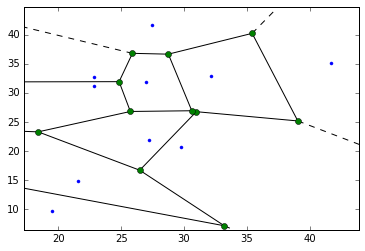

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
voronoi_plot_2d(vor)
plt.show()

In [41]:
# input a position and we'll tell you which idx of domain it belongs to 
vor.point_region

array([ 7,  8,  5,  6,  2,  1,  4, 10,  9,  0])

# import Chavis spot values

In [42]:
import generate_spot_values as gen
from itertools import product
players = [frame_data[team][j][2] for team,j in product(teams, range(5))]
players

SyntaxError: Missing parentheses in call to 'print' (generate_spot_values.py, line 141)

In [43]:
weight_func = lambda x: 1.0 / (1.0 + x)

In [47]:
from scipy.spatial import cKDTree
from functools import reduce
import generate_spot_values_backup as gen
# important!! get the consistent order for the players names
players = []
for team in teams:
    for i in range(5):
        players.append(frame_data[team][i][2])

def get_all_value(players, points, teams, frame_data):
    '''
    calculate every player's land value given the current frame's players' positions
    '''
    grid_centers, grid_vals = gen.get_midpoints_and_values()
    # calculate original land values
    player_value_orig_lst = {}
    vor_points = ds2points(frame_data, teams)
    kdtree_orig = cKDTree(points)
    for player in players:
        player_value_orig_lst[player] = []

    for i in range(10):
        for j in range(10):
            center = grid_centers[i][j]
            test_point_dist, test_point_regions = kdtree_orig.query(np.array(center).reshape((1,2)), k=1)
            player = players[test_point_regions]
            player_value_orig_lst[player].append((i,j,test_point_dist[0]))

    player_val_orig = {}
    for player in players:
        player_val_orig[player] = 0

    for player in players:
        for spot_i, spot_j, spot_dist in player_value_orig_lst[player]:
            player_val_orig[player] += weight_func(spot_dist) * grid_vals[spot_i][spot_i]
            
    return player_val_orig       

In [48]:
player_val_orig = get_all_value(players, points, teams, frame_data)
player_val_orig

/Users/Chengyu/anaconda3/envs/python34/lib/python3.4/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


{'Andre Drummond': 50.463260369823011,
 'JR Smith': 30.096063883525218,
 'Kentavious Caldwell-Pope': 85.22224634241141,
 'Kevin Love': 22.204632255322768,
 'Kyrie Irving': 28.876219925639127,
 'LeBron James': 54.014775928875331,
 'Marcus Morris': 72.465922611028475,
 'Reggie Jackson': 72.224451215664729,
 'Tobias Harris': 32.562601700645125,
 'Tristan Thompson': 52.989019085546246}

In [49]:
# a function to return the team of a player:
def get_player_team(player, teams, frame_data):
    for team in teams:
        for i in range(len(frame_data[team])):
#             print(frame_data[team][i][2])
            if frame_data[team][i][2] == player:
                return team
            
def get_other_team(player, teams, frame_data):
    player_team = get_player_team(player, teams, frame_data)
    return [t for t in teams if t!=player_team][0]

# Metric 1: the Diff in total offensive team land values if the player is not on court
# exciting part, leave one player out of the court and test reduction in the other team's land value!

In [50]:
# leave one out

out_player = "Andre Drummond"
out_player_idx = players.index(out_player)

team_4 = get_player_team(out_player, teams, frame_data)
team_5 = get_other_team(out_player, teams, frame_data)

# print(out_player_idx)
# print(team_4, team_5)
# print(teams)

In [51]:
players

['JR Smith',
 'Kevin Love',
 'Kyrie Irving',
 'LeBron James',
 'Tristan Thompson',
 'Andre Drummond',
 'Kentavious Caldwell-Pope',
 'Marcus Morris',
 'Reggie Jackson',
 'Tobias Harris']

In [52]:
from scipy.spatial import cKDTree
from functools import reduce

# get the leave one out player score

def get_leave1out_value(players, points, teams, frame_data, out_index):
    '''
    calculate every other player's land value leaving one player out of the court
    '''
    ##### modified from the all value funtion
    points = points[[x for x in range(10) if x!=out_index],:]
    grid_centers, grid_vals = gen.get_midpoints_and_values()
    # calculate original land values
    player_value_orig_lst = {}
    vor_points = ds2points(frame_data, teams)
    kdtree_orig = cKDTree(points)
    for player in players:
        player_value_orig_lst[player] = []

    for i in range(10):
        for j in range(10):
            center = grid_centers[i][j]
            test_point_dist, test_point_regions = kdtree_orig.query(np.array(center).reshape((1,2)), k=1)
            
            ##### modified from the all value funtion
            if test_point_regions >= out_index:
                test_point_regions += 1
            player = players[test_point_regions]
            
            player_value_orig_lst[player].append((i,j,test_point_dist[0]))

    player_val_orig = {}
    for player in players:
        player_val_orig[player] = 0

    for player in players:
        for spot_i, spot_j, spot_dist in player_value_orig_lst[player]:
            player_val_orig[player] += weight_func(spot_dist) * grid_vals[spot_i][spot_i]
    
#     print(players)
    out_player = players[out_index]
    player_val_orig[out_player] = 0
    
    return player_val_orig       

In [53]:
def value_of_player(players, points, teams, frame_data, out_player):
    '''
    value of the player is how important he is on court than if he is not
    calculate the team's total land values in two cases and subtract to get it
    '''
    if type(out_player) == str:
        out_index = players.index(out_player)
    else:
        raise Exception()
        
    player2team = {}
    for player in players:
        player2team[player] = get_player_team(player, teams, frame_data)

    team4 = get_player_team(out_player, teams, frame_data)
    team5 = get_other_team(out_player, teams, frame_data)
    val_orig = get_all_value(players, points, teams, frame_data)
    val_out  = get_leave1out_value(players, points, teams, frame_data, out_index)
    
    val_team_orig = {}
    val_team_out = {}
    for player in val_orig:
        his_team = player2team[player]
        if his_team not in val_team_orig:
            val_team_orig[his_team] = val_orig[player]
        else:
            val_team_orig[his_team] += val_orig[player]

    for player in val_out:
        his_team = player2team[player]
        if his_team not in val_team_out:
            val_team_out[his_team] = val_out[player]
        else:
            val_team_out[his_team] += val_out[player]
#     print(team5)
#     print(val_team_orig)
    result = {"team4":val_team_out[team4] - val_team_orig[team4],
              "team5":val_team_out[team5] - val_team_orig[team5],
             }
    return result


In [54]:
# get_all_value(players, points, teams, frame_data)
get_leave1out_value(players, points, teams, frame_data, 5)

/Users/Chengyu/anaconda3/envs/python34/lib/python3.4/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


{'Andre Drummond': 0,
 'JR Smith': 66.54104265125163,
 'Kentavious Caldwell-Pope': 85.648316762260322,
 'Kevin Love': 22.204632255322768,
 'Kyrie Irving': 28.876219925639127,
 'LeBron James': 54.014775928875331,
 'Marcus Morris': 72.465922611028475,
 'Reggie Jackson': 72.224451215664729,
 'Tobias Harris': 33.330131132993756,
 'Tristan Thompson': 54.633710763524292}

In [55]:
value_of_player(players, points, teams, frame_data, "Marcus Morris")
frame_result = {}
for player in players:
    val = value_of_player(players, points, teams, frame_data, player)
    frame_result[player] = np.abs(val['team4']) + np.abs(val['team5'])

frame_result

/Users/Chengyu/anaconda3/envs/python34/lib/python3.4/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/Chengyu/anaconda3/envs/python34/lib/python3.4/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


{'Andre Drummond': 87.35933096332991,
 'JR Smith': 44.852876750241364,
 'Kentavious Caldwell-Pope': 144.33394134039537,
 'Kevin Love': 41.278024142856282,
 'Kyrie Irving': 29.916419944292102,
 'LeBron James': 50.071120461660115,
 'Marcus Morris': 74.255366246042229,
 'Reggie Jackson': 119.96527615358934,
 'Tobias Harris': 42.337033863810461,
 'Tristan Thompson': 69.180604698629082}

{1610612739: 'r', 1610612765: 'b'}
['r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b']


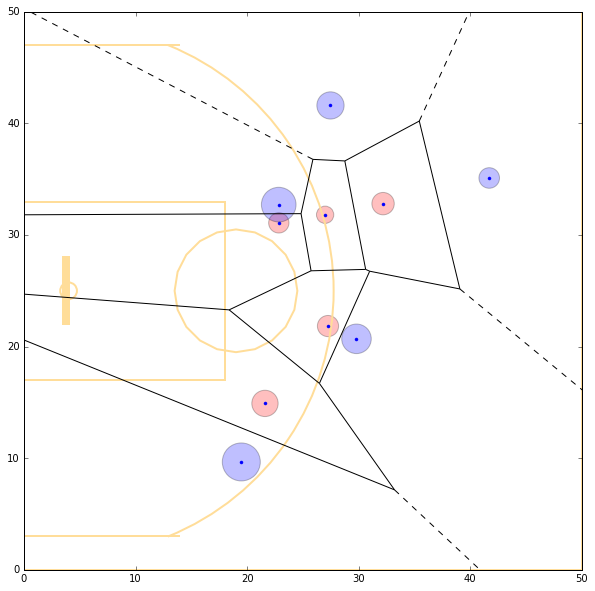

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
vor = Voronoi(points)
voronoi_plot_2d(vor, show_vertices=0)

size_circ = []
color_circ = []
team2color = {}
flag = False
for team in teams:
    team2color[team] = 'r' if not flag else 'b'
    flag = True
    
print(team2color)

for i in range(10):
    player = players[i]
    val = frame_result[player]
    size_circ.append(val)
    color_circ.append(team2color[get_player_team(player, teams, frame_data)])
    
size_circ = [x*10 for x in size_circ]
print(color_circ)



# plt.figure()
draw_court(color='#ffdd99',outer_lines=True)
plt.xlim(0,50)
plt.ylim(0,50)
# plt.show() 


import matplotlib.pyplot as plt
plt.scatter(points[:,0], points[:,1], s=size_circ, c=color_circ, alpha=0.25)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.gcf().set_size_inches(10, 10, forward=True)
plt.show()

{1610612739: 'r', 1610612765: 'b'}


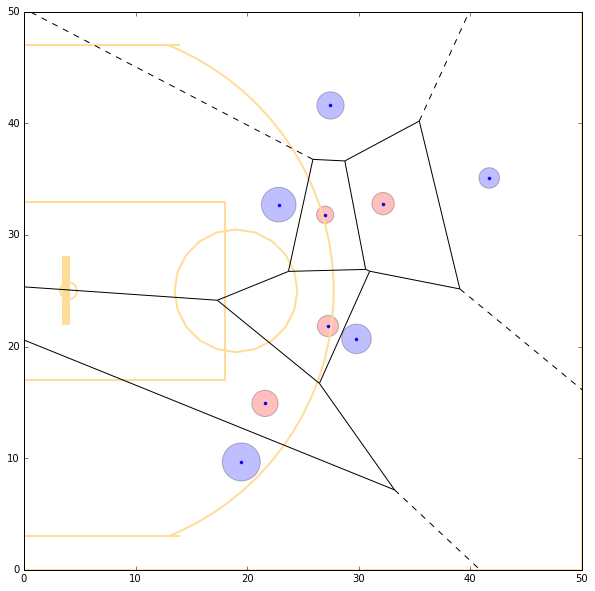

In [57]:
out_player = "Kevin Love"
out_index = players.index(out_player)
out_points = points[[x for x in range(10) if x!=out_index],:]

%matplotlib inline
import matplotlib.pyplot as plt
vor = Voronoi(out_points)
voronoi_plot_2d(vor, show_vertices=0)
size_circ = []
color_circ = []
team2color = {}

flag = False
for team in teams:
    team2color[team] = 'r' if not flag else 'b'
    flag = True
    
print(team2color)

for i in range(10):
    player = players[i]
    val = frame_result[player]
    size_circ.append(val)
    color_circ.append(team2color[get_player_team(player, teams, frame_data)])
    
del size_circ[out_index]
del color_circ[out_index]
    
    
draw_court(color='#ffdd99',outer_lines=True)
plt.xlim(0,50)
plt.ylim(0,50)
# plt.show() 
    
    
size_circ = [x*10 for x in size_circ]
import matplotlib.pyplot as plt
plt.scatter(out_points[:,0],out_points[:,1],s=size_circ,c=color_circ,alpha=0.25)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.gcf().set_size_inches(10, 10, forward=True)

plt.show()

In [58]:
# take 100 samples in time slices

N_sampels = 300
sample_rows = np.random.randint(0,len(df)-1,size=(N_sampels))

In [60]:
# sum over all the values of the player

game_stat_player = {}
game_score_player = {}
for player in players:
    game_stat_player[player] = []
    game_score_player[player] = 0
    for i in range(N_sampels):
        game_stat_player[player].append(game_stat[i][player])        
        game_score_player[player] += game_stat[i][player]

IndexError: list index out of range

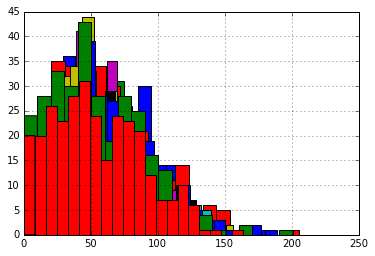

In [578]:
for player in players:
    pd.Series(game_stat_player[player]).hist(bins=20)

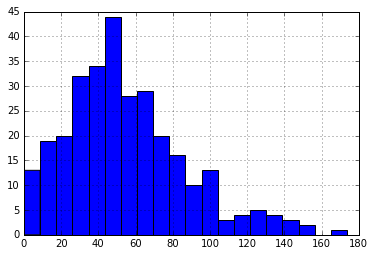

In [598]:
pd.Series(game_stat_player["Andre Drummond"]).hist(bins=20)

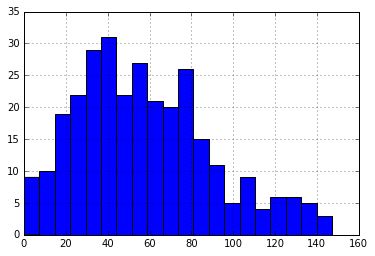

In [580]:
pd.Series(game_stat_player["LeBron James"]).hist(bins=20)

In [581]:
game_score_player

{'Andre Drummond': 16399.46105701114,
 'JR Smith': 17852.610626505801,
 'Kentavious Caldwell-Pope': 17503.88761278295,
 'Kevin Love': 17717.418610339799,
 'Kyrie Irving': 18007.276116227902,
 'LeBron James': 17343.091684050829,
 'Marcus Morris': 18021.836690089378,
 'Reggie Jackson': 16010.067066034761,
 'Tobias Harris': 16368.583132916268,
 'Tristan Thompson': 16553.480925519776}

# Metric 2: entropy metrics

In [596]:
import scipy
import numpy as np
import pandas as pd
import math
from scipy.stats import entropy

def get_player_entropy(player_points):
    '''
    list of the points a player stood in
    returns the entropy of places that a player covers
    operates by folding the half-court on the basket
    '''
    folded_court_rep = []
    for p in player_points:
        if p[1] > 4:
            p[1] = 4 - (p[1]-5)
        folded_court_rep.append(str(p[0]) + str(p[1]))
    probs = []
    for u in set(folded_court_rep):
        p_u = float(folded_court_rep.count(u)) / float(len(folded_court_rep))
        probs.append(p_u)
    return entropy(probs) 


def get_all_player_entropy(player_to_points):
    '''
    accepts a dictionary mapping player to the points they've stood in
    returns a dictionary mapping player to entropy of that player's points
    '''
    player_to_entropy = {}
    for p in player_to_points:
        player_to_entropy[p] = get_player_entropy(player_to_points[p])
    return player_to_entropy

In [584]:
frame_data

{'ball': [60.485130000000005, 38.396270000000001],
 1610612739: [(30.189509999999999, 7.9699399999999994, 'JR Smith'),
  (20.869050000000001, 47.918219999999998, 'Kyrie Irving'),
  (34.619019999999992, 38.211870000000005, 'LeBron James'),
  (28.253579999999999, 37.27487, 'Matthew Dellavedova'),
  (24.908119999999997, 18.90042, 'Tristan Thompson')],
 1610612765: [(13.665730000000011, 24.101779999999998, 'Andre Drummond'),
  (15.40419, 40.850879999999997, 'Kentavious Caldwell-Pope'),
  (20.349769999999992, 12.710239999999999, 'Marcus Morris'),
  (28.584569999999999, 33.133299999999998, 'Stanley Johnson'),
  (22.739509999999996, 30.560300000000002, 'Steve Blake')]}

In [585]:
def transf_frame_data(frame_data, players, teams):
    '''
    transform data structure for entropy calculation
    '''
    new_data = {}
    for player in players:
        for team in teams:
            for k in range(5):
                raw_data = frame_data[team][k]

In [593]:
grid_centers, grid_vals = gen.get_midpoints_and_values()
            
player_spot_lst = {}
for player in players:
    player_spot_lst[player] = []

entropy_stat = []
for sample in tqdm(sample_rows):
    frame_data = get_frame_data(df.iloc[sample], teams)
    points = ds2points(frame_data, teams)
    kdtree_orig = cKDTree(points)
    for i in range(10):
        for j in range(10):
            center = grid_centers[i][j]
            test_point_dist, test_point_regions = kdtree_orig.query(np.array(center).reshape((1,2)), k=1)
            player = players[test_point_regions]
            player_spot_lst[player].append([i,j])

100%|██████████| 300/300 [00:01<00:00, 231.54it/s]


In [597]:
get_all_player_entropy(player_spot_lst)

{'Andre Drummond': 3.6934732788915241,
 'JR Smith': 3.8751497704295153,
 'Kentavious Caldwell-Pope': 3.8749978107795542,
 'Kevin Love': 3.8905072964556422,
 'Kyrie Irving': 3.8852025633440435,
 'LeBron James': 3.8932905331228298,
 'Marcus Morris': 3.8640898689640215,
 'Reggie Jackson': 3.8721031791284171,
 'Tobias Harris': 3.8945519096433991,
 'Tristan Thompson': 3.8740878218059867}

# Metric 3 Raw Land Value

In [603]:
import generate_spot_values as gen
'''
accepts a list of the indices in the values matrix that the player owns
returns a summation of the value of the player's land
'''
def total_value_of_player_land(idxs):
    pos_values = gen.gen_position_values()
    total_val = 0.0
    for idx in idxs:
        total_val += pos_values[idx[0]][idx[1]]
    return total_val  


'''
accepts a dictionary mapping player name to a list of the points they own
returns a dictionary mapping player name to the total value of the points they own
'''
def all_players_land_value(players_dict):
    player_to_value = {}
    for p_name in players_dict:
        p_land = players_dict[p_name]
        player_to_value[p_name] = total_value_of_player_land(p_land)
    return player_to_value

In [604]:
all_players_land_value(player_spot_lst)

{'Andre Drummond': 103785.8999999998,
 'JR Smith': 120375.0999999995,
 'Kentavious Caldwell-Pope': 110647.49999999939,
 'Kevin Love': 116461.69999999943,
 'Kyrie Irving': 122227.49999999965,
 'LeBron James': 117621.69999999974,
 'Marcus Morris': 115579.99999999946,
 'Reggie Jackson': 115684.49999999921,
 'Tobias Harris': 114495.89999999959,
 'Tristan Thompson': 99340.1999999997}